# Diffusion problems
## (1) Head diffusion in one dimension
### Gorup members: Dominik Wolf, Hauke Lüdemann, Frayja Walberg

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### 3)  
Because the matrix has a triangonal form it is not necessary to store all the elements for most of them are 0. A possible way to store this sparse matrix is to only store the diagonal elements and the elements on the two side diagonals in three vectors. 
In order two create these vectors for different N we create a function. The vectors are created as shown in the first part (on the pdf).

In [2]:
def create_sparse_matrix(N):
    """Function to create the three vector for storing the matrix
    
    Args:
        N (int): Dimension of the matrix (NxN)
    Returns:
        np.array(N) (v1)  : Upper side diagonal elements
        np.array(N+1) (v2): Diagonal elements
        np.array(N) (v3)  : Lower side diagonal elements
    """
    v1 = np.ones(N) - np.identity(N)[0,:]    
    v2 = -2*np.ones(N + 1) + 3 * np.identity(N + 1)[0,:] + 3 * np.identity(N + 1)[-1,:]
    v3 = np.ones(N) - np.identity(N)[-1,:]
    
    return v1, v2, v3

In [3]:
def vec_mat(v1, v2, v3, vector):
    """Function to multiply the sparse matrix with a vector
    
    Args:
        v1 (np.array(N))   : Upper side diagonal elements
        v2 (np.array(N+1)) : Diagonal elements
        v3 (np.array(N))   : Lower side diagonal elements
        vector (nparray(N)): Vector to multiply tẃith the matrix
    Returns:
        np.array(N+1): Result of the vector matrix multiplication
    """
    
    result = np.zeros(len(vector))
    
    result[0] = v2[0] * vector[0] + v1[0] * vector[1]
    result[-1] = v2[-1] * vector[-1] + v3[-1] * vector[-2]
    
    result[1:-2] = np.dot(v3[:-1], vector[:-2]) + np.dot(v2[1:-1], vector[1:-1]) + np.dot(v1[1:],vector[2:])
        
    return result

In [4]:
# Forward-elimination backward-substition

def solve_matrix_equation(v1, v2, v3, inhomogeneity):
    """Function to solve the matrix equation using foward-elimination backward-substitution
    
    Args:
        v1 (np.array(N))         : Uppder side diagonal elements
        v2 (np.array(N+1))       : Diagonal elements
        v3 (np.array(N))         : Lower side diagonal elements
        inhomogenity (nparray(N)): Inhomogenity of the matrix equation
    Returns:
        np.array(N+1): Result of the matrix equation
    """
    diagonal = np.copy(v2)
    inhomo = np.copy(inhomogeneity)
    result = np.zeros(len(inhomogeneity))

    ## forward step of Gaussian elimination procedure:
    for i in range(1, len(inhomogeneity)):
        weight = v3[i-1]/diagonal[i-1]
        diagonal[i] -= weight*v1[i-1]
        inhomo[i] -= weight*inhomo[i-1]
    
    ## backward step of Gaussian elimination procedure:
    result[-1] = inhomo[-1]/diagonal[-1]
    for i in range(-2, -(len(inhomogeneity)+1), -1):
        result[i] = (inhomo[i]-v1[i+1]*result[i+1])/diagonal[i]
    return result

#### 4)
Test the matrix vector multiplication.

In [5]:
N = 10
v1, v2, v3 = create_sparse_matrix(N)
test_vector = np.ones(N+1)

result = vec_mat(v1, v2, v3, test_vector)
print(result) 

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


As expected the result of these multiplication is `[1,0,0,0,0,0,0,0,0,1]`.

#### 5) and 6) 
Testing and applying the matrix equation solver function to the diffusion problem.

In [6]:
N = 100
v1, v2, v3 = create_sparse_matrix(N)

In [7]:
# Inhomogenity as described in the first part of the exercise (on the pdf)
b = (-4 * np.ones(N+1) + 5 * np.identity(N+1)[0,:] + 5 * np.identity(N+1)[-1,:])
b[1:-1] /= N**2

solution_100 = solve_matrix_equation(v1, v2, v3, b)

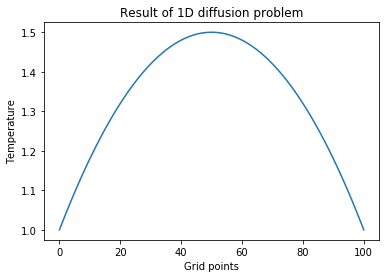

In [8]:
# Plot the solution
plt.xlabel("Grid points")
plt.ylabel("Temperature")
plt.title("Result of 1D diffusion problem")
plt.plot(range(0, N+1), solution_100)
plt.show()

As expected the remperature is highest at the center of the 1D block and decreases symmetrically to the bounderies.

#### 7)
Calculating the residuals to verify the result.

In [9]:
estimated_inhomo = vec_mat(v1, v2, v3, solution_100)
residuals = estimated_inhomo-b
variance_residuals = np.dot(residuals, residuals)/len(residuals)
print("Variance of the elements of the residual vector: ", variance_residuals)

Variance of the elements of the residual vector:  0.001490998811881735


The reason why the residual is not exactly zeros is due to rounding errors.

#### 9)
Solving the diffusion problem with 1000 grid points

In [10]:
## 1000
N = 1000

v1, v2, v3 = create_sparse_matrix(N)

b = (-4*np.ones(N+1)+5*np.identity(N+1)[0,:]+5*np.identity(N+1)[-1,:])
b[1:-1] /= N**2

solution_1000 = solve_matrix_equation(v1, v2, v3, b)

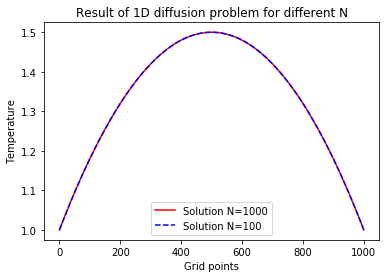

In [11]:
# Plot the solution for N = 100 and N = 1000
plt.xlabel("Grid points")
plt.ylabel("Temperature")
plt.title("Result of 1D diffusion problem for different N")
plt.plot(range(0, N+1), solution_1000, 'r', label="Solution N=1000")
plt.plot(range(0, N+1, 10), solution_100, 'b--', label="Solution N=100")
plt.legend()
plt.show()

As we can see in the plot above the result for different N is the same. Although the solution should get smoother for higher N the difference between N=100 and N=1000 is allready so small that it can't be seen in the plot.

#### 10) and 11) Jacobi iteration method

In [12]:
def jacobi(v1, v2, v3, inhomgeneity, seed):
    """Function to performe a single jacobi iteration step
    """
    return v2**(-1)*inhomgeneity + v2**(-1)*(np.concatenate(([0], -v3*seed[:-1])) + np.concatenate((-v1*seed[1:], [0])))

Solving the diffusion problem with N=8 and 30 iterations

In [13]:
N = 8

v1, v2, v3 = create_sparse_matrix(N)

b = (-4*np.ones(N+1)+5*np.identity(N+1)[0,:]+5*np.identity(N+1)[-1,:])
b[1:-1] /= N**2

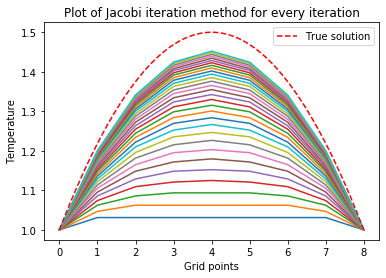

In [14]:
seed = np.ones(N+1)

for i in range(30):
    seed = jacobi(v1, v2, v3, b, seed)
    plt.plot(range(N+1), seed)
    
jacobi_result_30 = seed
    
plt.xlabel("Grid points")
plt.ylabel("Temperature")
plt.plot(N/1000*np.linspace(0, 1000, num=1001), solution_1000, 'r--', label="True solution")
plt.legend()
plt.title("Plot of Jacobi iteration method for every iteration")
plt.show()

#### 12)
Jacobi iteration for N=100

In [15]:
N = 100

v1, v2, v3 = create_sparse_matrix(N)

b = (-4*np.ones(N+1)+5*np.identity(N+1)[0,:]+5*np.identity(N+1)[-1,:])
b[1:-1] /= N**2

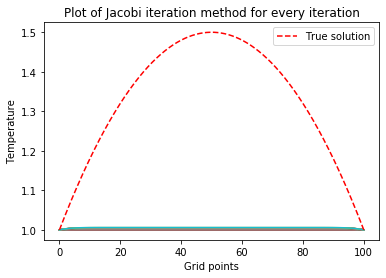

In [16]:
seed = np.ones(N+1)
for i in range(30):
    seed = jacobi(v1, v2, v3, b, seed)
    plt.plot(range(N+1), seed) 
    
plt.plot(N/1000*np.linspace(0, 1000, num=1001), solution_1000, 'r--', label="True solution")
plt.xlabel("Grid points")
plt.ylabel("Temperature")
plt.legend()
plt.title("Plot of Jacobi iteration method for every iteration")
plt.show()

As can be seen in the plot above increasing the number of grid points to 100 while not changing the iterations leads to a very bad result.
The reson for this is that is that due to the structure of the matrix (triagonal) onley adjacent grid cells will communicated in one iteration. So if we increase the number of grid points it will take longer for information to travel through the grid. This is the reason why we also need to increase the iterations in order to get a similar good result.

To illustrate this problem further we create some more plots for a different number of iterations and zeroes as initial seed.

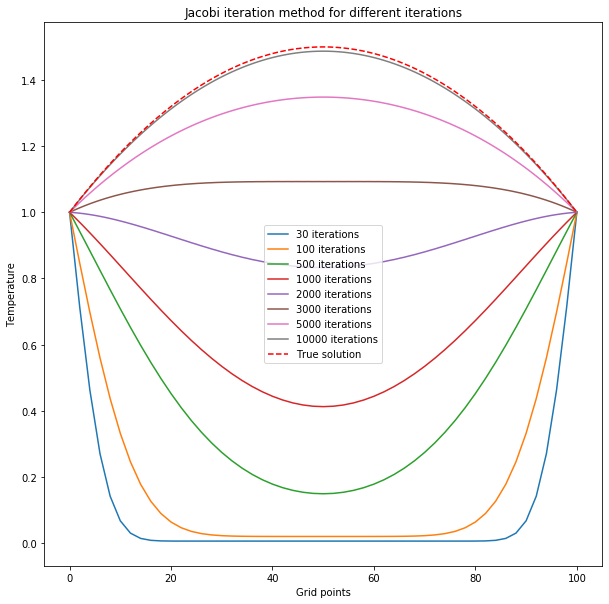

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))

number_iterations = [30, 100, 500, 1000, 2000, 3000, 5000, 10000]

i = 0
j = 0

for iterations in number_iterations:
    seed = np.zeros(N+1)
    
    for _ in range(iterations):
        seed = jacobi(v1, v2, v3, b, seed)
        
    ax.plot(range(N+1), seed, label="{} iterations".format(iterations))    
    
plt.plot(N / 1000 * np.linspace(0, 1000, num=1001), solution_1000, 'r--', label="True solution")
plt.title("Jacobi iteration method for different iterations")
plt.xlabel("Grid points")
plt.ylabel("Temperature")
plt.legend()
plt.show()

The plot above nicely illustrates that the information of the boundary condition travels further and further through the grid as the number of iterations are increased. If enough iterations are performed the jacobi iteration method approaches the same result as the true solution.

## (2) Solution with the multi grid method

#### 3)
Construct the matrices $R^3,R^2,R^1$ and $P^0,P^1,P^2$ und use them to calculate the restricted matrices $A^1,A^2,A^3$.

In [18]:
# Define the 9x9 matrix for the diffusion problem
N = 9-1  # Our convention

matrix = np.eye(9, k=1) - 2 * np.eye(9) + np.eye(9, k=-1)
matrix[0,0] = 1 
matrix[8,8] = 1
matrix[0,1] = 0
matrix[8,7] = 0

# Define the R matrices
R3 = 1.0/16.0 * (np.eye(5, 9, k=0) + 4 * np.eye(5, 9, k=1) + 6 * np.eye(5, 9, k=2) + 4 * np.eye(5, 9, k=3) + np.eye(5, 9, k=4))
R2 = 1.0/4.0 * (np.eye(3, 5, k=0) +  2 * np.eye(3, 5, k=1) + np.eye(3, 5, k=2))
R1 = 1.0/2.0 * (np.eye(2, 3, k=0) + np.eye(2, 3, k=1))

# Define the P matrices
P2 = R1.T
P1 = R2.T
P0 = R3.T

In [19]:
# Create the restricted matrices of the 9x9 matrix

A1 = np.dot(R3, np.dot(matrix, P0))
A2 = np.dot(R2, np.dot(A1, P1))
A3 = np.dot(R1, np.dot(A2, P2))

print("Intitial matrix:")
print(matrix)
print("\nRestricted matrices:")
print("5x5:")
print(A1)
print("3x3:")
print(A2)
print("2x2:")
print(A3)

Intitial matrix:
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.]]

Restricted matrices:
5x5:
[[-0.11328125 -0.05859375  0.03125     0.05078125  0.0234375 ]
 [-0.0546875  -0.109375   -0.0546875   0.03125     0.05078125]
 [ 0.03125    -0.0546875  -0.109375   -0.0546875   0.03125   ]
 [ 0.05078125  0.03125    -0.0546875  -0.109375   -0.0546875 ]
 [ 0.0234375   0.05078125  0.03125    -0.05859375 -0.11328125]]
3x3:
[[-0.06518555 -0.04052734  0.00537109]
 [-0.0402832  -0.06445312 -0.0402832 ]
 [ 0.00537109 -0.04052734 -0.06518555]]
2x2:
[[-0.0526123  -0.03497314]
 [-0.03497314 -0.0526123 ]]


#### 4)
Now we want to solve diffusion problem from above ($N=8 \rightarrow (9\times9)$ matrix) using the v-shaped multigrid procedure. For this we define the functions below.

In [20]:
def smoothing(matrix, x, b, steps=1):
    """Function to appliy 'steps' number of jacobi iterations.
    """
    D = np.triu(np.triu(matrix.T, k=0).T, k=0)
    L = -np.triu(matrix.T, k=1).T
    U = -np.triu(matrix, k=1)
    
    seed = x
    for _ in range(1):
        seed = np.dot(np.linalg.inv(D), b) + np.dot(np.linalg.inv(D), np.dot((L+U), seed))
        
    return seed

In [21]:
def residual(matrix, x, b):
    """Function to calculate the residual vector.
    """
    return b - np.dot(matrix, x)

In [22]:
def restriction(matrix, r):
    """Function to restrict the resuidual to the coarser grid.
    """
    return np.dot(matrix, r)

In [23]:
def prolongation(matrix, b):
    """Function to prolonge the obtained error to the finer grid.
    """
    return np.dot(matrix, b)

In [24]:
## Put the matrices in arrays for easy access in v_cycle.
# To generalize this function to arbitrary grid sizes this needs to be done in a different way.

R = [R3, R2, R1]
P = [P0, P1, P2]
A = [matrix, A1, A2, A3]

max_depth = 2

def v_cycle(x, b, i=0):
    """Function to recursivly sperforme one v cycle
    """

    x = smoothing(A[i], x, b)
    
    r = residual(A[i], x, b)
    
    rhs = restriction(R[i], r)
    
    eps = np.zeros(len(rhs))
    
    if i == max_depth:
        eps = smoothing(A[i+1], eps, rhs)
    else:
        eps = v_cycle(eps, rhs, i+1)
        
    x = x + prolongation(P[i], eps)
    
    return smoothing(A[i], x, b)
    

To obtain the solution with the multigrid method we will performe one v-cycle and use one jacobi iteration in every smoothing step of the algorithm. This result is then compared to the result we obtained using 30 jacobi iterations as well as well as with the true result dertermined in the first part.

In [25]:
# inhomgeneity 
b = (-4*np.ones(N+1)+5*np.identity(N+1)[0,:]+5*np.identity(N+1)[-1,:])
b[1:-1] /= N**2

# Performe one v-cycle
initial_guess = np.ones(N+1)

v_cycle_1 = v_cycle(initial_guess, b)

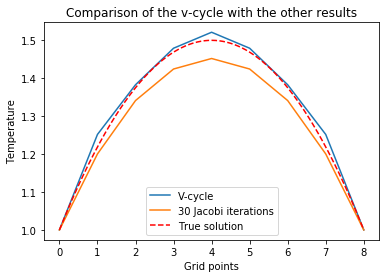

In [26]:
# Compare the result with the previous parts

plt.xlabel("Grid points")
plt.ylabel("Temperature")
plt.title("Comparison of the v-cycle with the other results")
plt.plot(range(N+1), v_cycle_1, label="V-cycle")
plt.plot(range(N+1), jacobi_result_30, label="30 Jacobi iterations")
plt.plot(N/1000*np.linspace(0, 1000, num=1001), solution_1000, 'r--', label="True solution")
plt.legend()
plt.show()

The plot above nicely shows that the v-cycle methods converges way faster then the plain jacobi method. This V-shaped multigrid method can now be used for multiple iterations to improve the result. 

In [27]:
# Multiple v-cycles

# inhomgeneity 
b = (-4*np.ones(N+1)+5*np.identity(N+1)[0,:]+5*np.identity(N+1)[-1,:])
b[1:-1] /= N**2

# Performe one v-cycle
v_cycle_3 = np.ones(N+1)

for _ in range(3):
    v_cycle_3 = v_cycle(v_cycle_3, b)

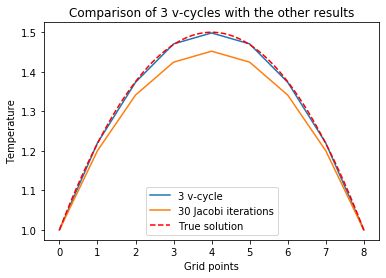

In [28]:
# Compare the result with the previous parts

plt.xlabel("Grid points")
plt.ylabel("Temperature")
plt.title("Comparison of 3 v-cycles with the other results")
plt.plot(range(N+1), v_cycle_3, label="3 v-cycle")
plt.plot(range(N+1), jacobi_result_30, label="30 Jacobi iterations")
plt.plot(N/1000*np.linspace(0, 1000, num=1001), solution_1000, 'r--', label="True solution")
plt.legend()
plt.show()

As we can see useing more v-cycles improves the result.